In [5]:
from datetime import datetime
from netCDF4 import Dataset, num2date
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from shapely.geometry import Point, Polygon
from xarray.backends import NetCDF4DataStore
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT,Hodograph
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo
import math

In [6]:
#These are the websites I have been using: 

#https://unidata.github.io/python-training/workshop/MetPy_Case_Study/metpy-case-study/

#https://unidata.github.io/python-training/workshop/Bonus/downloading-gfs-with-siphon/

#https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/201707/20170727/catalog.html?dataset=rap130anl-old/201707/20170727/rap_130_20170727_2300_001.grb2

#https://github.com/sharppy/SHARPpy/blob/master/sharppy/sharptab/thermo.py

#https://github.com/sharppy/SHARPpy/blob/master/sharppy/sharptab/params.py

#https://github.com/sharppy/SHARPpy/blob/master/examples/plot_sounding.py

In [120]:
def sounding(year, month, day, hour,lat1,lon1):
#creates datetime format
    dt=datetime(int(year), int(month), int(day), int(hour))


   # dt = datetime(int(year), int(month), int(day), int(hour))
    print(dt)
    
    print()
    storm=input('Storm Name:')
    radar=input('Radar site:')
    area=input('Upstream/Peak/Downstream:')
    print()
    
    f=open(r'C:\Users\spurpura\Desktop\Project\python\sounding\RAP.txt','w')
    
    
#will pull out the dataset and use subset to set up requesting a subset of the data
#'We can then use the ncss object to create a new query object, which facilitates asking for data from the server.'
#'We can look at the ncss.variables object to see what variables are available from the dataset:'
    ncss = NCSS(f'https://www.ncei.noaa.gov/thredds/ncss/model-rap130anl-old/{dt:%Y%m}/'
     f'{dt:%Y%m%d}/rap_130_{dt:%Y%m%d_%H}00_000.grb2')
    query = ncss.query()
    
    print('requesting data from thredds server...')
    print()
    
    
#make query to get data from the lat and long
# request data from input date and time
    query.lonlat_point(lon=lon1,lat=lat1).time(dt)
    query.accept('netcdf').add_lonlat()
    query.variables('Temperature_surface','Temperature_isobaric','Pressure_surface','Pressure_height_above_ground',
               'Geopotential_height_surface','Geopotential_height_isobaric','u-component_of_wind_isobaric',
               'v-component_of_wind_isobaric','Relative_humidity_isobaric','Relative_humidity_height_above_ground')
   
    
    
#'We now request data from the server using this query. The NCSS class handles parsing this NetCDF data
# '(using the netCDF4 module). If we print out the variable names, we
# 'see our requested variables, as well as a few others (more metadata information)'
    data = ncss.get_data(query)
    
    
    
    t=np.flip(units('kelvin')*(data['Temperature_isobaric'][:][0][0])).to('degC')
    
    p=np.flip(units('pascal')*data['isobaric'][:][0][0]).to('hPa')
    
    sfc_p=np.flip(units('pascal')*data['Pressure_surface'][:][0][0]).to('hPa')
    
    rh=np.flip(units('percent')*data['Relative_humidity_isobaric'][:][0][0])
    
    h=np.flip(units('meters')*data['Geopotential_height_isobaric'][:][0][0])
    
    h_sfc=((units('meters')*data['Geopotential_height_surface'][:][0][0]))
    
    u=np.flip(units('knots')*data['u-component_of_wind_isobaric'][:][0][0])
    
    v=np.flip(units('knots')*data['v-component_of_wind_isobaric'][:][0][0])
    
    wind_speed=mpcalc.wind_speed(u,v)
    

    
   #to get a closer isobaric layer to the surfcace layer
    if float(sfc_p.m)<=987. and float(sfc_p.m)>962.:
        t=t[1:]
        p=p[1:]
        u=u[1:]
        v=v[1:]
        rh=rh[1:]
        wind_speed=wind_speed[1:]
        h=h[1:]
    elif float(sfc_p.m)<=962. and float(sfc_p.m)>937.:
        t=t[2:]
        p=p[2:]
        u=u[2:]
        v=v[2:]
        rh=rh[2:]
        wind_speed=wind_speed[2:]
        h=h[2:]     
    elif float(sfc_p.m)<=937. and float(sfc_p.m)>912.:
        t=t[3:]
        p=p[3:]
        u=u[3:]
        v=v[3:]
        rh=rh[3:]
        wind_speed=wind_speed[3:]
        h=h[3:]
    elif float(sfc_p.m)<=912. and float(sfc_p.m)>887.:
        t=t[4:]
        p=p[4:]
        u=u[4:]
        v=v[4:]
        rh=rh[4:]
        wind_speed=wind_speed[4:]
        h=h[4:]
    elif float(sfc_p.m)<=887. and float(sfc_p.m)>862.:
        t=t[6:]
        p=p[6:]
        u=u[6:]
        v=v[6:]
        rh=rh[6:]
        wind_speed=wind_speed[6:]
        h=h[6:]
    
    print('Surface pressure:',np.around(sfc_p))
    print('Using as surface pressure:',p[0])
    print()
    
    f.write(str(np.around(sfc_p.m))+'\n'+str(p[0].m)+'\n')
    


#parcel stuff:
    
##calculating dewpoint from RH
    td=mpcalc.dewpoint_from_relative_humidity(t,rh)
    #print('dewpoint:',td)

##calculating the parcel profile
    prof=mpcalc.parcel_profile(p,t[0],td[0]).to('degC')
    #print('parcel prof:',prof)
    
##caculating potential temp
    theta=mpcalc.potential_temperature(p,t).m
    
##calculating mixing ratio using RH
    R=mpcalc.mixing_ratio_from_relative_humidity(rh[1:],t[1:],p[1:]).m
    
##calcualte LFL
    lcl_p,lcl_t=mpcalc.lcl(p[0],t[0],td[0]) 
    f.write(str(np.around(lcl_p.m))+'\n')
    print('LCL:',np.around(lcl_p))
    
##calculate LFC
    lfc_p,lfc_t=mpcalc.lfc(p,t,td,prof)
    f.write(str(np.around(lfc_p.m))+'\n')
    print('LFC:',np.around(lfc_p))
    
##calcualte EL
    el_p,el_t=mpcalc.el(p,t,td,prof)
    f.write(str(np.around(el_p.m))+'\n')
    print('EL:',np.around(el_p))
    
##calcualting theta-e
    thetaE=(mpcalc.equivalent_potential_temperature(p,t,td))
    thetae_mean=np.mean(thetaE)
    
    
##calulate wetbulb    
    wetbulb=mpcalc.wet_bulb_temperature(p,t,td)
    indx=(np.abs(wetbulb-0.0)).argmin()
 

    
    
    
    ##Sharppy calculation portion 
    def sharppy_calc(p, h, t, td, u, v):

        prof = profile.create_profile(profile='default', pres=p, hght=h, tmpc=t, dwpc=td, u=u, v=v, missing=-9999, strictQC=False)
        
        sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
        mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
        mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel

                
        sfc = prof.pres[prof.sfc]
        p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
        p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
        p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
    
    
        print('Height of 0 C:',np.around(sfcpcl.hght0c),'m')
        print('Height of -20 C:',np.around(sfcpcl.hghtm20c),'m')
        print('Wetbulb Zero Height:',np.around(h[indx].m),'m')
       
        
        f.write(str(np.around(sfcpcl.hght0c))+'\n'+str(np.around(sfcpcl.hghtm20c))
                +'\n'+str(np.around(sfcpcl.hghtm20c))+'\n'+
                str(np.around(h[indx].m))+'\n')

   # Calculate the 0-3 km pressure-weighted mean wind
        mean_3km = winds.mean_wind(prof, pbot=sfc, ptop=p3km)
        mean_6km = winds.mean_wind(prof, pbot=sfc, ptop=p6km)


   # Calculate the 0-1, 0-3, and 0-6 km wind shear
        sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
        sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
        sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
        shear_6km = utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1]

   # Calculate the Bunkers Storm Motion Left and Right mover vectors (these are returned in u,v space
   # so let's transform them into wind speed and direction space.)
        srwind = params.bunkers_storm_motion(prof)


   # Calculate the storm-relative helicity using the right-movers
        srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])
        srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])

   # and bottom of the layer.  We'll have to convert it from m MSL to m AGL.
        eff_inflow = params.effective_inflow_layer(prof)
        ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
        etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))

   # Like before, we can calculate the storm-relative helicity, but let's do it for the effective inflow layer.
        effective_srh = winds.helicity(prof, ebot_hght, etop_hght, stu = srwind[0], stv = srwind[1])

   # We can also calculate the Effective Bulk Wind Difference using the wind shear calculation and the inflow layer.
        ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
        ebwspd = utils.mag( ebwd[0], ebwd[1] )
    
   # Composite indices (e.g. STP, SCP, SHIP) can be calculated after determining the effective inflow layer.
        scp = params.scp(mupcl.bplus, effective_srh[0], ebwspd)
        stp_cin = params.stp_cin(mlpcl.bplus, effective_srh[0], ebwspd, mlpcl.lclhght, mlpcl.bminus)
        stp_fixed = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km[0], utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])
        ship = params.ship(prof)
         
        
        print('0-1 km SRH:',np.around(srh1km[0]), 'm2/s2')
        print('0-1 km Shear:',np.around(utils.comp2vec(sfc_1km_shear[0], sfc_1km_shear[1])[1]), 'kts')
        print('0-3 km SRH:',np.around(srh3km[0]), 'm2/s2')
        print('0-3 km Shear:',np.around(utils.comp2vec(sfc_3km_shear[0], sfc_3km_shear[1])[1]), 'kts')
        print('0-6 km Shear:',np.around(utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1]), 'kts')
        print('SBCAPE:',np.around(sfcpcl.bplus), 'J/kg')
        print('SBCIN:',np.around(sfcpcl.bminus), 'J/kg')
        print('MLCAPE:',np.around(mlpcl.bplus),'J/kg')
        print('MLCIN:',np.around(mlpcl.bminus),'J/kg')
        print('MUCAPE:',np.around(mupcl.bplus),'J/kg')
        print('MUCIN:',np.around(mupcl.bminus),'J/kg')
        print('STP(fix):',np.around(stp_fixed), 'flt')
        print('SCP:',np.around(scp), 'flt')
        print('STP(cin):',np.around(stp_cin), 'flt')
        
        f.write(str(np.around(srh1km[0]))+'\n'+str(np.around(utils.comp2vec(sfc_1km_shear[0], sfc_1km_shear[1])[1]))+
                '\n'+str(np.around(srh3km[0]))+'\n'+str(np.around(utils.comp2vec(sfc_3km_shear[0], sfc_3km_shear[1])[1]))+
                '\n'+str(np.around(utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1]))+'\n'+str(np.around(sfcpcl.bplus))+
                '\n'+str(np.around(sfcpcl.bminus))+'\n'+str(np.around(mlpcl.bplus))+'\n'+
               str(np.around(mlpcl.bminus))+'\n'+str(np.around(mupcl.bplus))+'\n'+
               str(np.around(mupcl.bminus))+'\n'+str(np.around(stp_fixed))+'\n'+str(np.around(scp))+'\n'+str(np.around(stp_cin))+'\n')

        
        #definition for lapse rate
        def lapse_rate(sfc_t,upper_t,sfc_h,upper_h):
            y=-((upper_t-sfc_t)/(upper_h-sfc_h))*1000
            return y
        
        if len(p)==37:
        #caclulates lapse rate for 0-3 (1000-700 hPa), 0-6 (1000-500 hPa),3-6 km (700-500 hPa) lapse rate 
            lapse3=(lapse_rate(t[0],t[12],h[0],h[12]))
            lapse6=(lapse_rate(t[0],t[20],h[0],h[20]))
            lapse3_6=(lapse_rate(t[12],t[20],h[12],h[20]))
        elif len(p)==36:
            lapse3=(lapse_rate(t[0],t[11],h[0],h[11]))
            lapse6=(lapse_rate(t[0],t[19],h[0],h[19]))
            lapse3_6=(lapse_rate(t[11],t[19],h[11],h[19]))
        elif len(p)==35:
            lapse3=(lapse_rate(t[0],t[10],h[0],h[10]))
            lapse6=(lapse_rate(t[0],t[18],h[0],h[18]))
            lapse3_6=(lapse_rate(t[10],t[18],h[10],h[18]))
        elif len(p)==34:
            lapse3=(lapse_rate(t[0],t[9],h[0],h[9]))
            lapse6=(lapse_rate(t[0],t[17],h[0],h[17]))
            lapse3_6=(lapse_rate(t[9],t[17],h[9],h[17]))
        elif len(p)==33:
            lapse3=(lapse_rate(t[0],t[8],h[0],h[8]))
            lapse6=(lapse_rate(t[0],t[16],h[0],h[16]))
            lapse3_6=(lapse_rate(t[8],t[16],h[8],h[16]))
        elif len(p)==32:
            lapse3=(lapse_rate(t[0],t[7],h[0],h[7]))
            lapse6=(lapse_rate(t[0],t[15],h[0],h[15]))
            lapse3_6=(lapse_rate(t[7],t[15],h[7],h[15]))   
        elif len(p)==31:
            lapse3=(lapse_rate(t[0],t[6],h[0],h[6]))
            lapse6=(lapse_rate(t[0],t[14],h[0],h[14]))
            lapse3_6=(lapse_rate(t[6],t[14],h[6],h[14]))
        elif len(p)==30:
            lapse3=(lapse_rate(t[0],t[5],h[0],h[5]))
            lapse6=(lapse_rate(t[0],t[13],h[0],h[13]))
            lapse3_6=(lapse_rate(t[5],t[13],h[5],h[13]))
    
    
        print('0-1 km lapse rate:',lapse3.m,'C/km')      
        print('0-6 km lapse rate:',lapse6.m,'C/km')
        print('3-6 km lapse rate:',lapse3_6.m,'C/km')
        
        f.write(str(lapse3.m)+'\n'+str(lapse6.m)+'\n'+
               str(lapse3_6.m)+'\n')
        
        #converts lapse rates to float and demensionless
        new_lapse3=float(lapse3.m) 
        new_lapse6=float(lapse6.m)
        new_lapse3_6=float(lapse3_6.m)
        
        #calcualte sherb parameter
        # 0-3km shear/26 * 0-3km lapse rate/5.2 * 3-6km lapse rate/5.6
        sherb=(((utils.comp2vec(sfc_3km_shear[0], sfc_3km_shear[1])[1])/26)*((new_lapse3/5.2)*((new_lapse3_6/5.6))))
        print('SHERB:',(sherb)) 

        f.write(str((sherb))+'\n')
    
    #Calls the defintion to calculate parameters using sharpy      
    sharppy_calc(p, h, t, td, u, v)
    
    #Theta-E parameters
    sfc_thetaE=np.around(thetaE[0].to('kelvin'))
    ml_thetaE=np.around(np.mean(thetaE[0:5]).to('kelvin'))
                         
    print('Surface Theta-E:',sfc_thetaE.m,)
    print("ML Theta-E:",ml_thetaE.m,)
    
    f.write(str(sfc_thetaE.m)+'\n'+str(ml_thetaE.m)+'\n')
    
  
    
    
    dcape_array=[]
    for i in range(0,14,1):
        if i==14:
            dcape=0
        else:
            dcape=-9.81*((prof[i]-t[0])/(t[i]))*(abs(h[i+1]-h[i]))
            dcape_array.append(dcape)
   
    
    dcape_sum=sum(dcape_array)
    print('DCAPE:',np.around(dcape_sum.m),'J/kg')
    
    f.write(str(np.around(dcape_sum.m)))
    
        
    print()
    print('********************')
    print()
    print('creating sounding...')
    
    
    
    
    
    
##Change default to be better for skew-T
    fig = plt.figure(figsize=(10,10))
    skew = SkewT(fig,rotation=45)

##Plot the data using normal plotting functions, in this case using
##log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, t, 'r')
    skew.plot(p, td, 'g')
    skew.plot_barbs(p[:-1:2], u[:-1:2], v[:-1:2])

##Add the relevant special lines
    skew.plot_dry_adiabats(t0=np.arange(233,533,10)*units('K'),alpha=0.25)
    skew.plot_moist_adiabats(t0=np.arange(233,323,5)*units('K'),alpha=0.25)
    skew.plot_mixing_lines(alpha=0.25)
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40,40)

##Calculate full parcel profile and add to plot as black line
##Requires that the variables have associated units
    #prof = mpcalc.parcel_profile(p, t[0], td[0]).to('degC')
    skew.plot(p, prof, 'k', linewidth=2)


##this will add a line and place where the LCL is located
    skew.plot(lcl_p,lcl_t.to('degC'), marker='_',  markersize=22, color='blue')
    plt.text(lcl_t.to('degC').m+5,lcl_p.m+20,'LCL',color='blue',size=14)

##this will add a line and place where the LFC is located
    skew.plot(lfc_p,lfc_t.to('degC'), marker='_',  markersize=22, color='blue')
    plt.text(lfc_t.to('degC').m+5,lfc_p.m+20,'LFC',color='blue',size=14)

##this will add a line and place where the EL is located
    skew.plot(el_p,el_t.to('degC'), marker='_',  markersize=22, color='blue')
    plt.text(el_t.to('degC').m+5,el_p.m+20,'EL',color='blue',size=14)

    
##Make some titles
    plt.title('Lat:'+str(lat1)+' Lon:'+str(lon1),loc='left')
    plt.title(dt,loc='right') 
    plt.title(str(storm)+' '+str(area),loc='center')

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
    ax_hod = inset_axes(skew.ax, '20%', '20%', loc=1)
    ho = Hodograph(ax_hod, component_range=80.)
    ho.add_grid(increment=20)
    ho.plot_colormapped(u, v, wind_speed)  # Plot a line colored by wind speed


##show the plot
    plt.tight_layout()
 #   plt.savefig(str(radar)+'_'+str(storm)+'_'+str(area)+'_'+str(year)+'_'+str(month)+'_'+str(day)+'_'+str(hour)+'.png',dpi=150)
    plt.show()
    
   
  

2016-05-02 00:00:00

Storm Name:
Radar site:
Upstream/Peak/Downstream:

requesting data from thredds server...

Surface pressure: 948.0 hectopascal
Using as surface pressure: 950.0 hectopascal

LCL: 890.0 hectopascal
LFC: 832.0 hectopascal
EL: 272.0 hectopascal


C:\Users\spurpura\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:1423: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


Height of 0 C: 3614.0 m
Height of -20 C: 6846.0 m
Wetbulb Zero Height: 3114.0 m
0-1 km SRH: 30.0 m2/s2
0-1 km Shear: 7.0 kts
0-3 km SRH: 57.0 m2/s2
0-3 km Shear: 14.0 kts
0-6 km Shear: 29.0 kts
SBCAPE: 1084.0 J/kg
SBCIN: -34.0 J/kg
MLCAPE: 1039.0 J/kg
MLCIN: -10.0 J/kg
MUCAPE: 1167.0 J/kg
MUCIN: -5.0 J/kg
STP(fix): 0.0 flt
SCP: 1.0 flt
STP(cin): 0.0 flt
0-1 km lapse rate: 6.918473169207573 C/km
0-6 km lapse rate: 6.345788948237896 C/km
3-6 km lapse rate: 5.792269483208656 C/km
SHERB: 0.760509181156566
Surface Theta-E: 334.0
ML Theta-E: 333.0
DCAPE: 1444.0 J/kg

********************

creating sounding...


C:\Users\spurpura\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:397: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


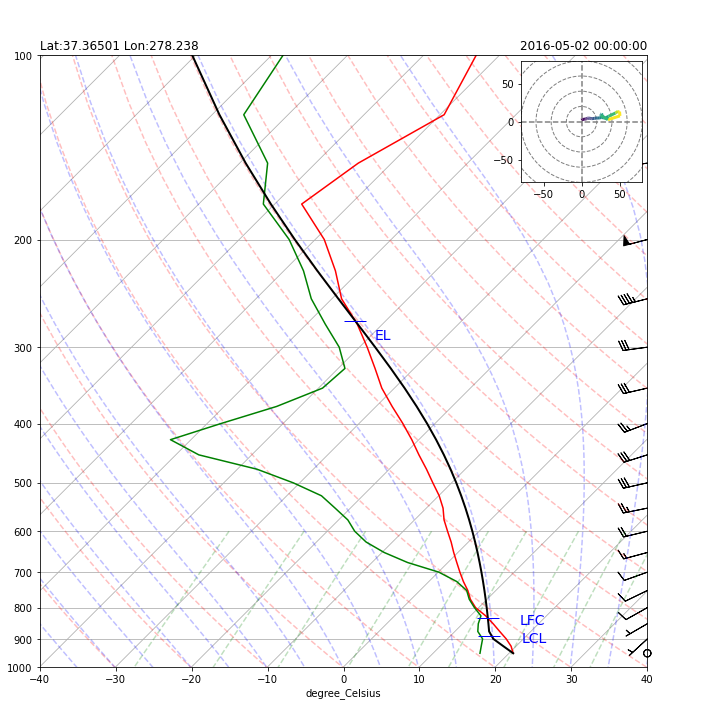

In [135]:
# input(yyyy,m,d,h,lat,lon)

sounding(2016,5,2,0,37.36501,278.238)